In [ ]:
%matplotlib inline
import os
import sys
import gc
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from commons.configuration_manager import ConfigurationManager
from src.learning.training.training_transformer import TrainingTransformer
from src.learning.training.label_collector import LabelCollector
from src.learning.training.training_file_reader import TrainingFileReader
from src.learning.models import create_cnn, create_mlp, create_multi_model

In [1]:
config_manager = ConfigurationManager()
config = config_manager.config

reader = TrainingFileReader(path_to_training='../../training/laps/')
transformer = TrainingTransformer(config)
collector = LabelCollector()

# axis=2 for frames, axis=0 for telem and diffs
def memory_creator(instance, memory, length=4, interval=2, axis=2):
    memory.append(instance)
    
    near_memory = memory[::-interval]
    if len(near_memory) < length:
        return None
    
    if len(memory) >= length * interval:
        memory.pop(0)
        
    return np.concatenate(near_memory, axis=axis)


def read_stored_data(filename):
    df = reader.read_telemetry_as_csv(filename + '.csv')
    telemetry = collector.collect_numeric_inputs(df)
    diffs = collector.collect_expert_labels(df)

    frames = reader.read_training_video(filename + '.avi')
    resized_frames_np = transformer.resize_video_for_training(frames)

    return resized_frames_np, telemetry, diffs


def prep_full_mem_datas(frames, telemetry, diffs, length, interval):    
    mem_slice_frames = []
    mem_slice_telemetry = []
    
    mem_frames = []
    for frame in frames:
        mem_frame = memory_creator(frame, mem_slice_frames, length=length, interval=interval, axis=2)

        if mem_frame is not None:
            mem_frames.append(mem_frame)
    mem_frames_np = np.array(mem_frames)
    
    mem_telemetry = []
    for index, telem in telemetry.iterrows():
        mem_telem = memory_creator(telem, mem_slice_telemetry, length=length, interval=interval, axis=0)

        if mem_telem is not None:
            mem_telemetry.append(mem_telem)
    mem_telemetry_np = np.array(mem_telemetry)
    
    mem_diffs = diffs
    len_diff = diffs.shape[0] - mem_frames_np.shape[0]
    if len_diff > 0:
        mem_diffs = mem_diffs.iloc[len_diff:]
    mem_diffs_np = mem_diffs.to_numpy()
    
    assert mem_frames_np.shape[0] == mem_telemetry_np.shape[0] == mem_diffs_np.shape[0], "Lengths differ!"
    return mem_frames_np, mem_telemetry_np, mem_diffs_np


def prep_mem_datas(frames, telemetry, diffs, length, interval):
    mem_telemetry = telemetry
    mem_diffs = diffs
    
    memory = []
    mem_frames = []
    for frame in frames:
        mem_frame = memory_creator(frame, memory, length=length, interval=interval, axis=2)

        if mem_frame is not None:
            mem_frames.append(mem_frame)

    mem_frames_np = np.array(mem_frames)

    len_diff = mem_telemetry.shape[0] - mem_frames_np.shape[0]
    if len_diff > 0:
        mem_telemetry = mem_telemetry.iloc[len_diff:]
        mem_diffs = mem_diffs.iloc[len_diff:]
    
    mem_telemetry_np = mem_telemetry.to_numpy()
    mem_diffs_np = mem_diffs.to_numpy()

    return mem_frames_np, mem_telemetry_np, mem_diffs_np


def plot_stuff(title, plot_elems, figsize=(18, 10)):
    fig=plt.figure(figsize=figsize)
    plt.title(title)
    #plt.ylabel('dunno')
    plt.xlabel('Epoch')
    x = np.arange(0, len(plot_elems[0]['data']), 1)
    
    for plot_elem in plot_elems:
        plt.errorbar(x, plot_elem['data'], yerr=plot_elem['error'], label=plot_elem['label'], alpha=plot_elem['alpha'], fmt='-o', capsize=5)

    plt.grid(axis='x')
    plt.legend(loc='best', prop={'size': 15})
    plt.show()
    plt.savefig('./' + title + '.png')

    
filenames = ['lap_5_2020_01_24', 'lap_6_2020_01_24', 'lap_7_2020_01_24']

In [2]:
frames, telems, diffs = read_stored_data(filenames[0])
mem_frames, mem_telems, mem_diffs = prep_full_mem_datas(*read_stored_data(filenames[0]), 4, 1)

print(mem_frames.shape)
print(mem_telems.shape)
print(mem_diffs.shape)

(4165, 40, 60, 12)
(4165, 16)
(4165, 4)


In [3]:
experiments = [(1, 1), (4, 1), (8, 1), (16, 1)]
datas_list = []

for experiment in tqdm(experiments):
    frames_mem = None
    telemetry_mem = None
    diffs_mem = None
    
    for training_file in filenames:
        frames_i, telem_i, diffs_i = prep_full_mem_datas(*read_stored_data(training_file), *experiment)
        
        if frames_mem is None and telemetry_mem is None and diffs_mem is None:
            frames_mem = frames_i
            telemetry_mem = telem_i
            diffs_mem = diffs_i
        else:
            frames_mem = np.append(frames_mem, frames_i, axis=0)
            telemetry_mem = np.append(telemetry_mem, telem_i, axis=0)
            diffs_mem = np.append(diffs_mem, diffs_i, axis=0)
        gc.collect()
        
    datas_list.append((frames_mem, telemetry_mem, diffs_mem))

In [6]:
epochs = 20
batch_size = 32
verbose = 0

results = {}

for data in tqdm(datas_list):
    result_desc = "N={}, M={}".format(*experiments[datas_list.index(data)])
    tqdm.write(result_desc)
    
    losses = []
    val_losses = []
    for i in tqdm(range(0, 15)):
        frames_train, frames_test, telemetry_train, telemetry_test, diffs_train, diffs_test = train_test_split(*data, test_size=0.2)
        
        mlp = create_mlp(input_shape=telemetry_train[0].shape)
        cnn = create_cnn(input_shape=frames_train[0].shape)
        multi = create_multi_model(mlp, cnn)
    
        hist = multi.fit([telemetry_train, frames_train], diffs_train,
                        validation_data=([telemetry_test, frames_test], diffs_test),
                        epochs=epochs, batch_size=batch_size, verbose=verbose)
        
        losses.append(hist.history['loss'])
        val_losses.append(hist.history['val_loss'])
    
        gc.collect()
    
    mean_losses = [np.mean(i) for i in zip(*losses)]
    std_losses = [np.std(i) for i in zip(*losses)]
    mean_val_losses = [np.mean(i) for i in zip(*val_losses)]
    std_val_losses = [np.std(i) for i in zip(*val_losses)]
    
    results[result_desc] = mean_losses
    results[result_desc + ' std'] = std_losses
    results[result_desc + ' val'] = mean_val_losses
    results[result_desc + ' val std'] = std_val_losses
    
    tqdm.write("Mean loss per epoch: {}".format(mean_losses))
    tqdm.write("Mean validation loss per epoch: {}".format(mean_val_losses))
    
    gc.collect()

N=1, M=1



Mean loss per epoch: [0.31359377827707324, 0.18069595449021744, 0.1252402359249065, 0.09565520664168299, 0.07785764541754679, 0.06484306383378108, 0.05391363253260374, 0.044063214752098914, 0.038028139483555636, 0.03328282491100071, 0.0290156681479995, 0.02551663557119395, 0.022665918359582152, 0.02043994691447845, 0.01893999925562975, 0.01784505944565684, 0.01689509454890758, 0.016085100239139203, 0.01560774699468615, 0.015327436659872918]
Mean validation loss per epoch: [0.2089463000751938, 0.13265645681280336, 0.09920793338822971, 0.08158085887569352, 0.06834332930327158, 0.05740134890023671, 0.0470518755980351, 0.03875128898397124, 0.03427643591914672, 0.030422121321355872, 0.026929311179836758, 0.023909653600054606, 0.021522108603618136, 0.01976290364862138, 0.01859496543311599, 0.01757023462241953, 0.01667673577792109, 0.016025396592463458, 0.015674065142068535, 0.01550720495040999]
N=4, M=1


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.3283701553812478, 0.18645335634281437, 0.12758486475211658, 0.10105143263805605, 0.08266713642085842, 0.06826125793412739, 0.056140699220386746, 0.04599688114257062, 0.03952538285460371, 0.03477826615480607, 0.030565069122776227, 0.026862154139961777, 0.023879293998555547, 0.02163344520669339, 0.019942379266882186, 0.018447448306197208, 0.01724388973415787, 0.01642913885931354, 0.016013132724421716, 0.01571189121448988]
Mean validation loss per epoch: [0.2175435790478183, 0.13172844356770136, 0.10457207689897047, 0.08670049189527829, 0.07272372127665604, 0.06033675921242015, 0.049407479213153145, 0.04105838938529115, 0.03618234648019505, 0.03206563150028673, 0.028524311682839185, 0.02523170801177085, 0.02267266036838079, 0.02080583101601677, 0.01921215044129059, 0.017859041732086016, 0.016803922444769588, 0.016219860031882555, 0.015900492019508015, 0.0156210055984981]
N=8, M=1


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.3554418863785728, 0.21095502159883922, 0.1426308032911205, 0.10955525249509036, 0.08720511551174827, 0.07044066653889586, 0.05736296276569313, 0.04589437545992719, 0.039769063766511396, 0.035420997733633296, 0.03150489849865173, 0.02799334943475327, 0.024896339258031166, 0.02225107897371614, 0.020109459047930402, 0.01838235517975158, 0.017348381594422084, 0.016593537614198413, 0.015996606518317105, 0.015557173425587443]
Mean validation loss per epoch: [0.23911142173958946, 0.15739790326357464, 0.1164655713243452, 0.09620942068202662, 0.07624339873958187, 0.06307679361789169, 0.05078071930853066, 0.041555892693849406, 0.03715199876209461, 0.03329484189108511, 0.029843796853539932, 0.02658489488698281, 0.023693922509619224, 0.021338596825428647, 0.019411875646300737, 0.018020636220664188, 0.017213052636437385, 0.01651658605460955, 0.015995876594874857, 0.015665191505830574]
N=16, M=1


/home/martin/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  



Mean loss per epoch: [0.347396609830014, 0.20777867787024978, 0.1499874367702612, 0.11988575949899655, 0.0945388955630969, 0.07435818228500878, 0.0573146324527576, 0.04226152955892172, 0.03556814765741629, 0.03173074379507824, 0.028306036988280874, 0.02526399562617451, 0.02253228571007198, 0.020401446862872336, 0.018735182354953236, 0.017674303908767015, 0.01692109315426932, 0.016347939220034514, 0.015813211420050925, 0.015493105716066206]
Mean validation loss per epoch: [0.2336438572301355, 0.15980713244345685, 0.12825208219804476, 0.10393367829528143, 0.0824635728652296, 0.06555274334671359, 0.049780768863727884, 0.037998784761424716, 0.033970938550157245, 0.030376956449310995, 0.027145141599608905, 0.024209324930254218, 0.021844445740995994, 0.019931964167407706, 0.018582062569712902, 0.01772922017203908, 0.017088057461074026, 0.016524620459392465, 0.016087120357012503, 0.015867096922130845]



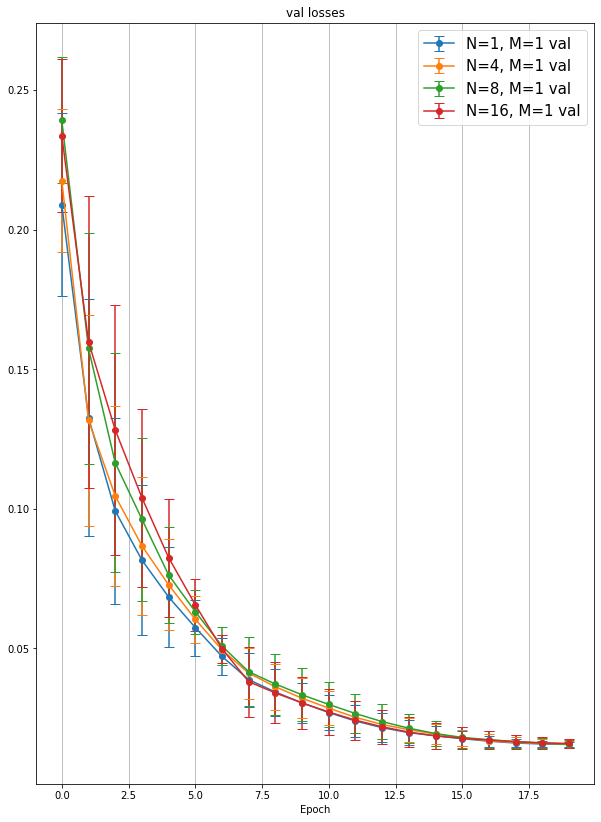

<Figure size 432x288 with 0 Axes>

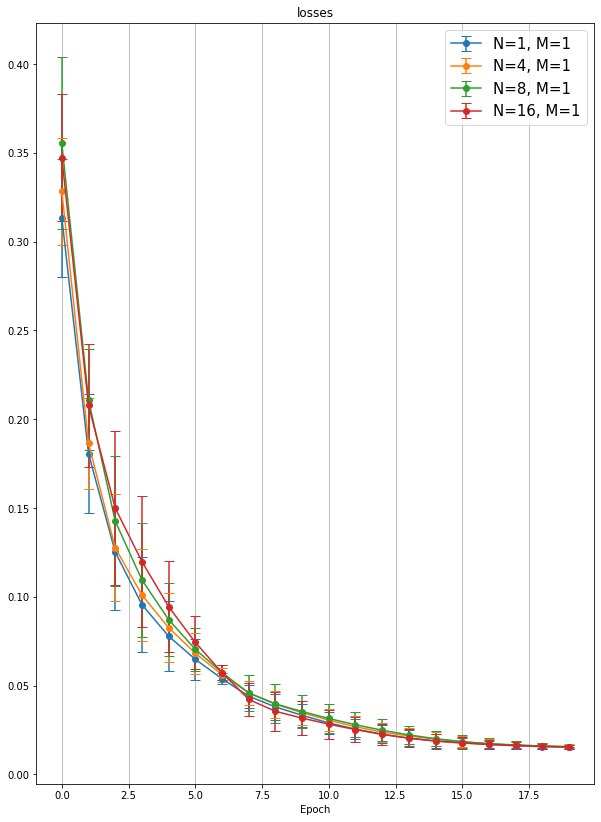

<Figure size 432x288 with 0 Axes>

In [7]:
loss_data = []
val_loss_data = []

for key, loss in results.items():
    if 'std' in key or 'raw' in key:
        continue
    
    if 'val' in key:
        val_loss_data.append({'data': loss, 'error': results[key + ' std'], 'label': key, 'alpha': 1.0})
    else:
        loss_data.append({'data': loss, 'error': results[key + ' std'], 'label': key, 'alpha': 1.0})
        
plot_stuff("val losses", val_loss_data, figsize=(10, 14))
plot_stuff("losses", loss_data, figsize=(10, 14))

In [ ]:
mlp = create_mlp()
cnn = create_cnn(input_shape=frames_train[0].shape)
multi = create_multi_model(mlp, cnn)
#multi.summary()

from keras.utils import plot_model
plot_model(multi, to_file='../../../Downloads/multi_model.png')